# **Hits Prediction Model**

**Background:**

In Marketing Intelligence, analytics play a vital role in getting insights from data and using these to help optimize marketing campaigns. A very common use case that we find in marketing analytics is to predict hits and clicks for a website that helps the SEO or SEM analysts to better design their marketing strategies and optimize the important KPIs like Clicks Per Visit, Revenue Per Click, Cost Per Click etc.

**Objective:**

The focus of this analysis is to build a Machine Learning Model that can accurately predict number of hits per session.

**Data:**

A csv file containing information of about nine hundred thousand sessions. The columns should be understood as follows:
* row_num: a number uniquely identifying each row.
* locale: the platform of the session.
* day_of_week: Mon-Fri, the day of the week of the session.
* hour_of_day: 00-23, the hour of the day of the session.
* agent_id: the device used for the session.
* entry_page: describes the landing page of the session.
* path_id_set: shows all the locations that were visited during the session.
* traffic_type: indicates the channel the user cane through eg. search engine, email, ...
* session_duration: the duration in seconds of the session.
* hits: the number of interactions with the page during the session.

Predict for rows having missing values under "hits" column

**Evalution Metric:**

Root Mean Squared Error = sqrt(mean((actual - error)^2))


In [72]:
# Import required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import catboost 
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBRegressor
from sklearn import preprocessing


**Data Imputation**

In [73]:
# Data Import
data = pd.read_csv("../input/sem-data/Data.csv", sep=";")

**Data Pre-processing**

In [74]:
# Data Cleaning
data['flag']=['train' if x != '\\N' else 'test' for x in data['hits']]
data['hits'] = data['hits'].replace('\\N',np.nan)
data['session_durantion'] = data['session_durantion'].replace('\\N',np.nan)
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data.path_id_set[data.path_id_set.notnull()] = data.path_id_set[data.path_id_set.notnull()].map(lambda x: [i.strip() for i in x.split(";")])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
# Type Conversion
data.hour_of_day = data.hour_of_day.astype('object')
data.agent_id = data.agent_id.astype('object')
data.entry_page = data.entry_page.astype('object')
data.traffic_type = data.traffic_type.astype('object')

In [76]:
# New variable to calculate #paths visited in a session
data['no_paths'] = 0
data['no_paths'][data.path_id_set.notnull()]=data.path_id_set[data.path_id_set.notnull()].apply(len)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
# One-hot Encoding for Categorical Variables
objects = list(data.select_dtypes(include=['category','object']))
objects = [e for e in objects if e not in ('flag', 'hits','path_id_set','session_durantion')]
objects

#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        columnsToEncode = [e for e in columnsToEncode if e not in {'session_durantion','hits','flag','path_id_set'}]
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                exec('df[\''+feature+'_old\'] = df[\''+feature+'\']')
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df
    
data = dummyEncode(data)

In [78]:
# Missing value imputation using median of columns
my_imputer = SimpleImputer(strategy='median')
imputed_data = my_imputer.fit_transform(data[['locale','day_of_week','hour_of_day','agent_id','entry_page','traffic_type','session_durantion','no_paths']])

imputed_data = pd.DataFrame(imputed_data)
imputed_data.columns = data[['locale','day_of_week','hour_of_day','agent_id','entry_page','traffic_type','session_durantion','no_paths']].columns

for i in objects:
    exec('imputed_data = pd.merge(imputed_data,data[[\''+i+'\',\''+i+'_old\']].drop_duplicates(),on=\"'+i+'\",how=\"left\")')
    exec('imputed_data.'+i+' = imputed_data.'+i+'_old')
    exec('imputed_data.drop(\''+i+'_old\',axis=1,inplace=True)')
    
imputed_data = pd.concat([imputed_data,data.drop(['locale','day_of_week','hour_of_day','agent_id','entry_page','traffic_type','session_durantion','no_paths'],axis=1)],axis=1)
imputed_data.drop(imputed_data.filter(regex='old').columns,axis=1,inplace=True)

tmp = imputed_data['row_num']
imputed_data.drop(labels=['row_num'], axis=1,inplace = True)
imputed_data.insert(0, 'row_num', tmp)
imputed_data.head()
data = imputed_data

In [79]:
# Dummy variable to check if path id 0 exists for a session
data['path_0'] = 0
data.path_0[data.path_id_set.notnull()] = data.path_id_set[data.path_id_set.notnull()].apply(lambda x: x.count('0'))
data.path_0 = data.path_0.astype('object')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
# Function for outliers
def outliers(x):
    qnt = np.quantile(x, [0.25, 0.75])
    caps = np.quantile(x, [0.05, 0.95])
    H = 1.5 * (x.quantile(.75)-x.quantile(0.25))
    x[x < (qnt[0] - H)] = caps[0]
    x[x > (qnt[1] + H)] = caps[1]
    return x

In [2]:
# Removing the data point with highest hits 
# Removing one row with the highest #hits (4174) from the analysis as it is totally deviated from normal population
cleaned_data = data[data.hits!='4174']
cleaned_data = cleaned_data[cleaned_data.session_durantion.notnull()]
print(data.shape)
print(cleaned_data.shape)

**Exploratory Data Analysis**

In [ ]:
# Correlation
cleaned_data.corr()

* Log transformed the target variable for modeling to suppress the effect of outliers.
* Though transformation did not help to improve the final accuracy, it helped to reduce the residual numbers (abs error) for most population
* Log transformation helps in using the full information for modeling rather than dropping the outlier cases

<function matplotlib.pyplot.show(*args, **kw)>

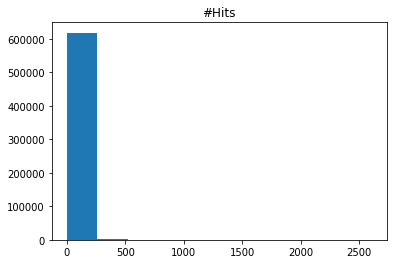

In [81]:
#Histogram of hits
plt.hist(cleaned_data[cleaned_data.flag=="train"].hits.astype('int'))
plt.title('#Hits')
plt.show

In [106]:
#Hits by percentile range
np.quantile(cleaned_data.session_durantion,[0.01,0.25,0.5,0.75,0.99])

array([0.00e+00, 4.00e+00, 5.70e+01, 3.23e+02, 5.22e+03])

Text(0.5, 1.0, 'Session Duration - Test')

<Figure size 432x288 with 0 Axes>

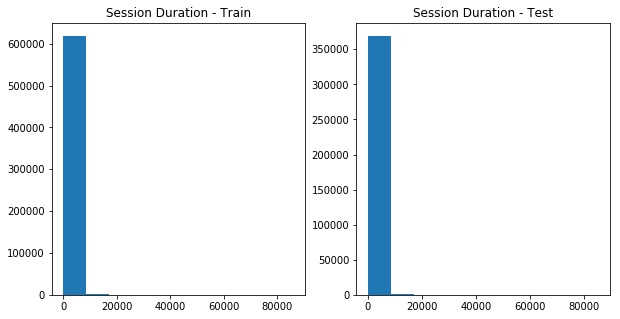

In [84]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(cleaned_data.session_durantion[cleaned_data.flag=="train"])
plt.title('Session Duration - Train')
plt.subplot(1,2,2)
plt.hist(cleaned_data.session_durantion[cleaned_data.flag=="test"])
plt.title('Session Duration - Test')

In [85]:
#Session duration by percentile
print(np.quantile(cleaned_data.session_durantion[cleaned_data.flag=="train"],[0.25,0.5,0.75,0.99]))
print(np.quantile(cleaned_data.session_durantion[cleaned_data.flag=="test"],[0.25,0.5,0.75,0.99]))

[4.000e+00 5.900e+01 3.270e+02 5.283e+03]
[4.000e+00 5.500e+01 3.260e+02 5.232e+03]


* It is very important to check and compare the distribution of train and test data before the modeling exercise
* This is to make sure that the test data is sample representation of train data
* Also, this helps to create variables that might capture abnormalities in the test data, if any
* A new Agent ID – ‘6’ appears in the test data, however not in the train set
* Test set contains more sessions with high number of paths traversed compared to train set (This might be potentially due to the new Agent ID, however needs to be verified)

<Figure size 432x288 with 0 Axes>

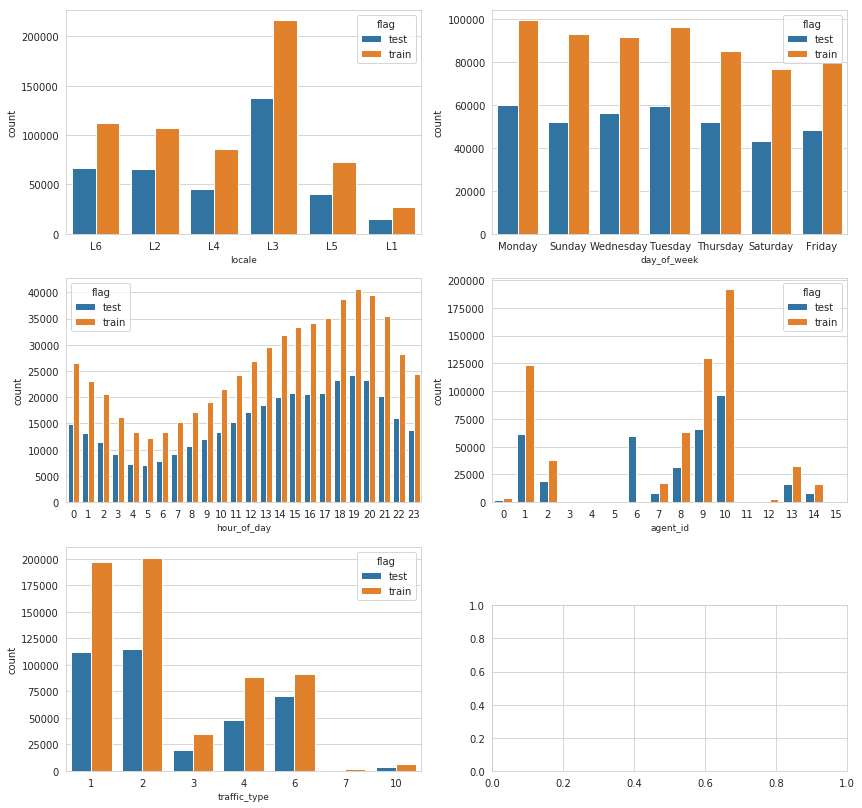

In [86]:
#Train Vs Test Plots
def plot_feature_bar(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,2,figsize=(14,14))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        sns.countplot(x=feature,hue="flag", data=df)
        plt.xlabel(feature, fontsize=9)
    plt.show();
    
features = ['locale','day_of_week','hour_of_day','agent_id','traffic_type']
plot_feature_bar(cleaned_data, features)

A new agent id '6' appears only in the test set and not in train set
    59,698 rows (16%) 

<Figure size 432x288 with 0 Axes>

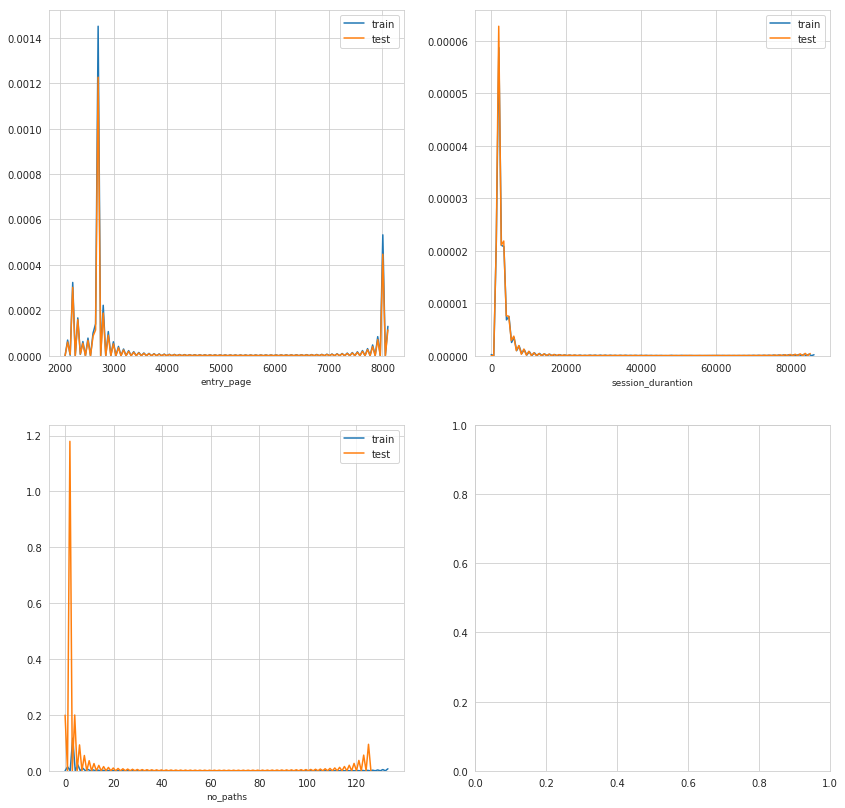

In [87]:
#Density Plots
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(14,14))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(2,2,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = ['entry_page','session_durantion','no_paths',]
plot_feature_density(data[data.flag=="train"],data[data.flag=="test"],'train','test', features)

* All IDVs are plotted against target variable ‘hits’ to view their relationship
* Since hits is highly skewed, all IDVs are plotted against log transformed hits variable to see their distribution
* Agent ID, Traffic Type and Locale are the major categorical variables that show difference in their distribution with target variable ‘hits’ 
* Median of each of the categorical variables against hits differ significantly (please note that hits are log transformed)

<Figure size 432x288 with 0 Axes>

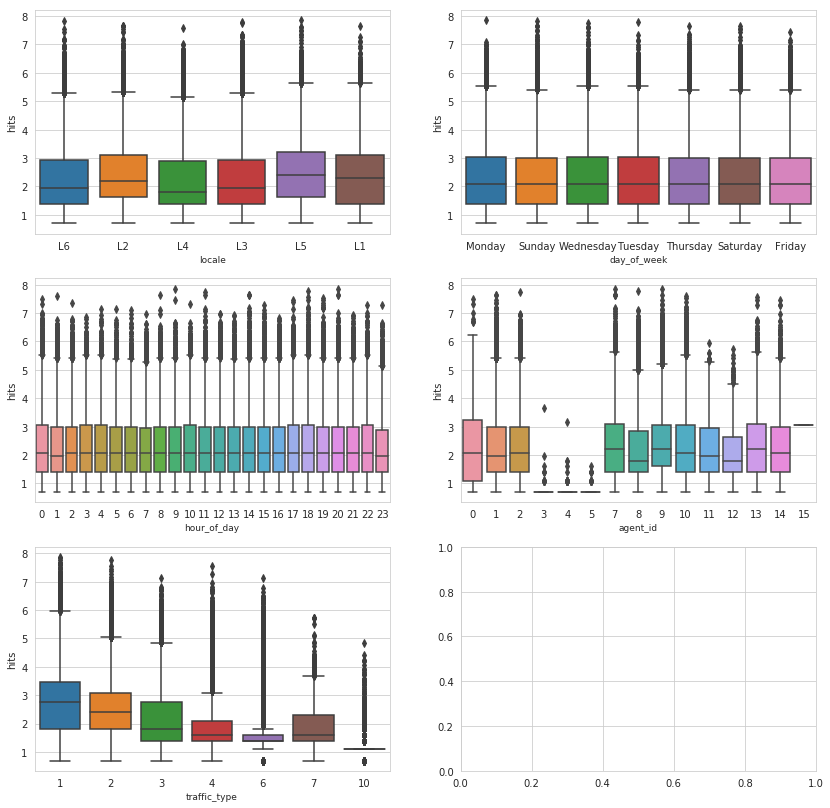

In [92]:
#Multivariate Plots
def plot_feature_box(df,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(14,14))
    df.hits = df.hits.astype('int')
    df.hits = np.log(df.hits+1)
    
    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        sns.boxplot(x=feature,y='hits', data=df)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = ['locale','day_of_week','hour_of_day','agent_id','traffic_type']
plot_feature_box(cleaned_data[cleaned_data.flag=="train"],features)

<Figure size 432x288 with 0 Axes>

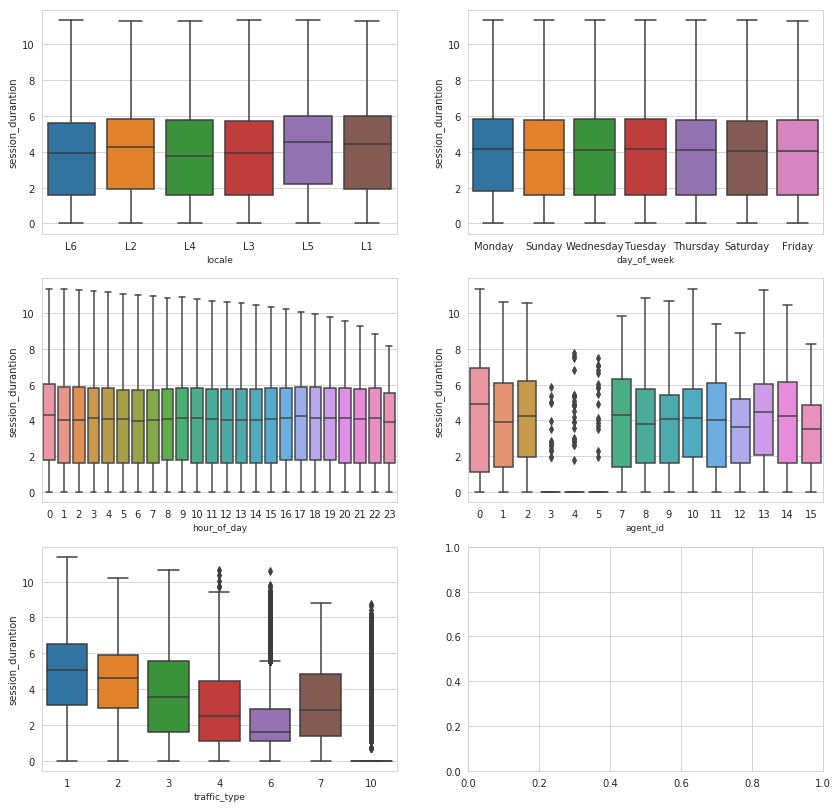

In [99]:
#Session duration Vs Other Numerical Variables
def plot_feature_box(df,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(14,14))
    df.session_durantion = np.log(df.session_durantion+1)

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        sns.boxplot(x=feature,y='session_durantion', data=df)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = ['locale','day_of_week','hour_of_day','agent_id','traffic_type']
plot_feature_box(cleaned_data[cleaned_data.flag=="train"],features)

In [113]:
cleaned_data.session_durantion = cleaned_data.session_durantion.astype('int')

In [114]:
# Categorical vars
objects = list(cleaned_data.select_dtypes(include=['category','object']))
objects = [e for e in objects if e not in ('flag', 'hits','path_id_set')]

**Feature Engineering**

Based on the information obtained from univariate/ multivariate analysis, created around 80+ additional variables to capture the interactions among the data points

Below are the idea behind creating these variables.

What is the normal behaviour of the dataset? 
* Calculated mean/ median/ frequency statistics for session duration and #paths across all categorical variables

How are the data points deviated from normal behaviour? 
* Created lift variables to show the percentage deviation of every data point from mean/ median range of all categorical variables

What information is the path ids providing? 
* Created dummies for top 20 path ids with highest number of visits to show the presence/ absence of those ids in the data points
* Also created dummy variables for top 20 path ids with highest number of visits from those sessions with high hits (sessions with hits greater than 160 – 99th percentile & above) compared to others


In [115]:
# Derived Variables Creation
for i in objects:
    tmp = eval('pd.DataFrame(cleaned_data.'+i+'.value_counts().rename_axis(\''+i+'\').reset_index(name=\''+i+'_count\'))')
    cleaned_data = eval('pd.merge(cleaned_data,tmp,on=\''+i+'\')')
    
cleaned_data['avg_session_duration'] = cleaned_data.session_durantion.mean()
cleaned_data['median_session_duration'] = cleaned_data.session_durantion.median()

cleaned_data['lift_avg_session'] = np.where((cleaned_data.session_durantion).isna(),0,
                                            np.where((cleaned_data.session_durantion)==0,0,
                                            round(cleaned_data.session_durantion/cleaned_data.avg_session_duration,2)))

cleaned_data['lift_med_session'] = np.where((cleaned_data.session_durantion).isna(),0,
                                            np.where((cleaned_data.session_durantion)==0,0,
                                            round(cleaned_data.session_durantion/cleaned_data.median_session_duration,2)))

cleaned_data['avg_no_paths'] = cleaned_data.no_paths.mean()
cleaned_data['med_no_paths'] = cleaned_data.no_paths.median()

cleaned_data['lift_avg_paths'] = np.where((cleaned_data.no_paths).isna(),0,
                                            np.where((cleaned_data.no_paths)==0,0,
                                            round(cleaned_data.no_paths/cleaned_data.avg_no_paths,2)))

cleaned_data['lift_med_paths'] = np.where((cleaned_data.no_paths).isna(),0,
                                            np.where((cleaned_data.no_paths)==0,0,
                                            round(cleaned_data.no_paths/cleaned_data.med_no_paths,2)))

for i in objects:
    tmp=eval('pd.DataFrame(cleaned_data[[\''+i+'\',\'session_durantion\']].groupby([\''+i+'\']).mean().reset_index())')
    eval('tmp.rename(columns={\'session_durantion\':\'avg_session_durantion_'+i+'\'},inplace=True)')
    cleaned_data = eval('pd.merge(cleaned_data,tmp,on=\''+i+'\')')
    
for i in objects:
    tmp=eval('pd.DataFrame(cleaned_data[[\''+i+'\',\'session_durantion\']].groupby([\''+i+'\']).median().reset_index())')
    eval('tmp.rename(columns={\'session_durantion\':\'med_session_durantion_'+i+'\'},inplace=True)')
    cleaned_data = eval('pd.merge(cleaned_data,tmp,on=\''+i+'\')')
    
for i in objects:
    exec('cleaned_data[\'lift_avg_session_'+i+'\'] = np.where((cleaned_data.session_durantion).isna(),0,np.where((cleaned_data.session_durantion)==0,0,round(cleaned_data.session_durantion/cleaned_data.avg_session_durantion_'+i+',2)))')
    exec('cleaned_data[\'lift_med_session_'+i+'\'] = np.where((cleaned_data.session_durantion).isna(),0,np.where((cleaned_data.session_durantion)==0,0,round(cleaned_data.session_durantion/cleaned_data.med_session_durantion_'+i+',2)))')
    
for i in objects:
    tmp=eval('pd.DataFrame(cleaned_data[[\''+i+'\',\'no_paths\']].groupby([\''+i+'\']).mean().reset_index())')
    eval('tmp.rename(columns={\'no_paths\':\'avg_no_paths_'+i+'\'},inplace=True)')
    cleaned_data = eval('pd.merge(cleaned_data,tmp,on=\''+i+'\')')
    
for i in objects:
    tmp=eval('pd.DataFrame(cleaned_data[[\''+i+'\',\'no_paths\']].groupby([\''+i+'\']).median().reset_index())')
    eval('tmp.rename(columns={\'no_paths\':\'med_no_paths'+i+'\'},inplace=True)')
    cleaned_data = eval('pd.merge(cleaned_data,tmp,on=\''+i+'\')')

for i in objects:
    exec('cleaned_data[\'lift_avg_no_paths_'+i+'\'] = np.where((cleaned_data.no_paths).isna(),0,np.where((cleaned_data.no_paths)==0,0,round(cleaned_data.no_paths/cleaned_data.avg_no_paths_'+i+',2)))')
    exec('cleaned_data[\'lift_med_no_paths_'+i+'\'] = np.where((cleaned_data.no_paths).isna(),0,np.where((cleaned_data.no_paths)==0,0,round(cleaned_data.no_paths/cleaned_data.med_no_paths'+i+',2)))')
    

In [116]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988680 entries, 0 to 988679
Data columns (total 84 columns):
row_num                               988680 non-null int64
locale                                988680 non-null object
day_of_week                           988680 non-null object
hour_of_day                           988680 non-null object
agent_id                              988680 non-null object
entry_page                            988680 non-null object
traffic_type                          988680 non-null object
session_durantion                     988680 non-null int64
no_paths                              988680 non-null float64
path_id_set                           983791 non-null object
hits                                  619234 non-null object
flag                                  988680 non-null object
path_0                                988680 non-null object
locale_count                          988680 non-null int64
day_of_week_count                    

In [117]:
# Creating dummy variables for top 15 path id
tmp = cleaned_data.path_id_set.apply(pd.Series) \
    .merge(cleaned_data[['row_num']], right_index = True, left_index = True) \
    .melt(id_vars = ['row_num'], value_name = "path_freq") \
    .sort_values(['row_num']) \
    .drop("variable", axis = 1) \
    .dropna()

training = cleaned_data[cleaned_data.flag=="train"]
training.hits = training.hits.astype('int')

tmp['flag']=np.where(tmp.row_num.isin(training.row_num[training.hits>np.quantile(training.hits,[0.9][0])].tolist()),1,0)

# These are top 15 path ids where sessions with high hits 
imp_paths = list(['2','1','31490','31467','34372','31029','31491','34387','34227','581','31030','31481','34287','50799','34225'])

final = tmp[tmp['path_freq'].isin(imp_paths)]

df_dummies = pd.get_dummies(
    final[['path_freq']].apply(lambda x: '_'.join(x.astype(str)), axis=1),
    prefix_sep='')

final = pd.concat([final["row_num"], df_dummies], axis=1)

cleaned_data = pd.merge(cleaned_data,final,on='row_num',how='left')

cleaned_data = cleaned_data.fillna(0)

cleaned_data.drop('path_id_set',axis=1,inplace=True)

**Model Data Preparation**

In [71]:
## Splitting data into train and test
train = cleaned_data[cleaned_data.flag=="train"]
test = cleaned_data[cleaned_data.flag=="test"]
train.drop(['flag'], axis=1, inplace=True)
test.drop('flag', axis=1, inplace=True)

train.hits = train.hits.astype('int')

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [118]:
#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        columnsToEncode = [e for e in columnsToEncode if e not in {'hits','flag'}]
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                #exec('df[\''+feature+'_old\'] = df[\''+feature+'\']')
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

train = dummyEncode(train)    


In [121]:
train.hits = train.hits.astype('int')

In [123]:
# Strategy for Stratified KFold for Regression
train['hits_bins']= pd.qcut(train.hits, 10)
X = train
y = train.hits_bins

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20, random_state=0)

cols=["row_num"]
X_train = X_train.drop(cols,axis=1)
X_test = X_test.drop(cols,axis=1)

label_encoder = LabelEncoder()
X_train.hits_bins = label_encoder.fit_transform(X_train.hits_bins)
X_test.hits_bins = label_encoder.fit_transform(X_test.hits_bins)

**Modeling**

Building an efficient ML model using CatBoost (after attempting XGBoost & LightGBM)

* Using 5 cross-validation for building a robust model that gives consistent results for all data samples and averaged out the results of all 10 CatBoost models to get the final output. This helps to avoid over-fitting and get consistent results for test sample as well. 
* Log transformed DV helped to a certain extent in reducing the overall RMSE.


In [124]:
#Parameters for CatBoost
cb_model = CatBoostRegressor(iterations = 5000,
                                eval_metric='RMSE',
                               learning_rate = 0.1,
                               use_best_model = True,
                               depth = 6,
                               od_type = "Iter",
                               od_wait = 500,random_seed=0
                                )

In [125]:
## Running 5 folds cross validation 
from sklearn.model_selection import StratifiedKFold, KFold

def run_CB(X, y, n_folds = 5, seed = 0):
    oof_train = np.zeros((X.shape[0],))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    X.hits = np.log(X.hits+1)
    X.session_durantion = np.log(X.session_durantion+1)
    #X, y = train[feature_names], train.amount_spent_per_room_night_scaled.values
    
    preds = np.zeros(X_test.shape[0])
    
    for i, (itr, icv) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[itr, :], X.iloc[icv, :]
        y_train, y_val = X_train['hits'], X_val['hits']
        X_train.drop(['hits','hits_bins'], axis=1, inplace=True)
        X_val.drop(['hits','hits_bins'], axis=1, inplace=True)
        cb_model.fit(X_train, y_train,
                     eval_set=(X_val,y_val),
                     use_best_model=True,
                     verbose=100)
        #score_, iter_ = bst.best_score['eval']['rmse'], bst.best_iteration
        oof_train[icv] = cb_model.predict(X_val)
        test_preds = cb_model.predict(X_test)
        test_preds = np.exp(test_preds)-1
        #test_preds = np.square(np.exp(test_preds)-1)
        preds += test_preds
    return oof_train, preds / n_folds

In [126]:
oof_train,output = run_CB( X_train,X_train.hits_bins)
output = np.round(output,0)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0:	learn: 2.2819992	test: 2.2810008	best: 2.2810008 (0)	total: 156ms	remaining: 12m 59s
100:	learn: 0.4900106	test: 0.4899692	best: 0.4899692 (100)	total: 9.66s	remaining: 7m 48s
200:	learn: 0.4851322	test: 0.4865430	best: 0.4865430 (200)	total: 18.7s	remaining: 7m 26s
300:	learn: 0.4823646	test: 0.4853957	best: 0.4853957 (300)	total: 27.6s	remaining: 7m 10s
400:	learn: 0.4802788	test: 0.4848243	best: 0.4848235 (399)	total: 36.5s	remaining: 6m 58s
500:	learn: 0.4785138	test: 0.4845262	best: 0.4845262 (500)	total: 45.4s	remaining: 6m 47s
600:	learn: 0.4769434	test: 0.4843071	best: 0.4842965 (598)	total: 54.1s	remaining: 6m 36s
700:	learn: 0.4754268	test: 0.4842506	best: 0.4842410 (686)	total: 1m 2s	remaining: 6m 25s
800:	learn: 0.4740461	test: 0.4842374	best: 0.4842036 (733)	total: 1m 11s	remaining: 6m 15s
900:	learn: 0.4726490	test: 0.4842502	best: 0.4842036 (733)	total: 1m 20s	remaining: 6m 7s
1000:	learn: 0.4712599	test: 0.4842302	best: 0.4842036 (733)	total: 1m 29s	remaining: 5m 58s

Though most of the derived variables are highly correlated to each other, all the variables are passed as input to CatBoost model due to its high robustness to multi-collinearity unlike linear regression
* Those variables that indicate the deviation/lift from mean/median position are identified as most significant by the model

Text(0.5, 0, 'Importance')

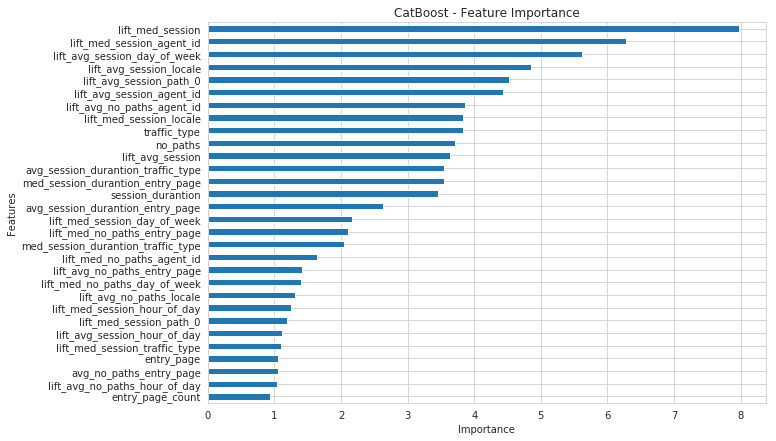

In [127]:
# Feature Importance Plot
fea_imp = pd.DataFrame({'imp': cb_model.feature_importances_, 'col': X_train.columns[(X_train.columns!='hits') & (X_train.columns!='hits_bins')]})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

**Model Results Analysis**

Since RMSE is very sensitive to outliers and also the target variable is highly skewed, it is also good to look at Root Median Squared Error to access the performance of the model

* Cross Validation Root Mean Squared Error: 31.42
* Cross Validation Root Median Squared Error: 2


It is very evident from Root Median Squared Error that the model performs well for normal population, however RMSE is highly biased towards outliers

In [128]:
# RMSE
np.sqrt(np.mean((X_test.hits-output)*(X_test.hits-output)))

31.422108094407616

In [129]:
# Root Median Squared Error
np.sqrt(np.median((X_test.hits-output)*(X_test.hits-output)))

2.0

In [130]:
# Quantile of RMSE
np.quantile(np.sqrt((X_test.hits-output)*(X_test.hits-output)),[0.1,0.25,0.5,0.75,0.9,0.99])

array([  0.,   0.,   2.,   8.,  20., 116.])

Residuals are high for sessions with high values of hits

Text(0, 0.5, 'Residuals')

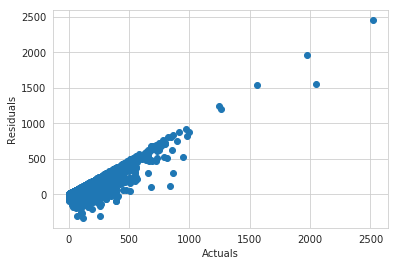

In [131]:
#Actuals Vs Residuals Plot
plt.scatter(X_test.hits,X_test.hits-output)
plt.xlabel('Actuals')
plt.ylabel('Residuals')

RMSE is biased due to the few data points with high absolute error for extreme predicted values as shown in the below graph

Text(0, 0.5, 'Residuals')

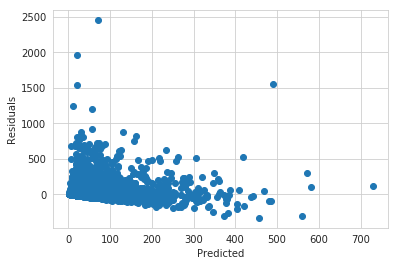

In [132]:
#Predicted Vs Residuals Plt
plt.scatter(output,X_test.hits-output)
plt.xlabel('Predicted')
plt.ylabel('Residuals')

Text(0, 0.5, 'Standardized Residuals')

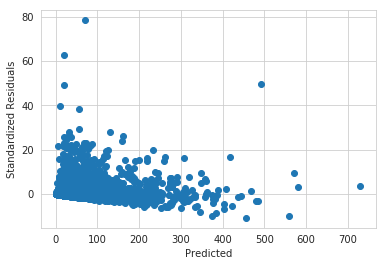

In [133]:
#Predicted Vs Standardized Residuals Plot
plt.scatter(output,preprocessing.scale(X_test.hits-output))
plt.xlabel('Predicted')
plt.ylabel('Standardized Residuals')

Text(0, 0.5, 'Predicted')

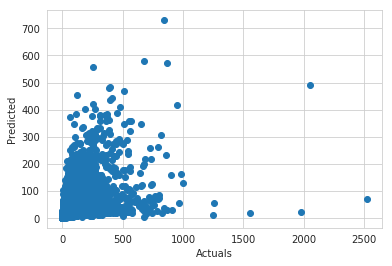

In [134]:
#Actuals Vs Predicted Plot
plt.scatter(X_test.hits,output)
plt.xlabel('Actuals')
plt.ylabel('Predicted')

**Final Model for Test Data**

In [135]:
#Final Prediction for the real test data using the average of results from 10 cross validation from whole dataset
cleaned_data = dummyEncode(cleaned_data)   

## Splitting data into train and test
train = cleaned_data[cleaned_data.flag=="train"]
test = cleaned_data[cleaned_data.flag=="test"]
train.drop(['flag','row_num'], axis=1, inplace=True)
test.drop('flag', axis=1, inplace=True)

train.hits = train.hits.astype('int')

def run_final_CB(X, X_test,n_folds = 10, seed = 0):
    oof_train = np.zeros((X.shape[0],))
    kf = KFold(n_splits=10, shuffle=True, random_state=7)
    X.hits = np.log(X.hits+1)
    X.session_durantion = np.log(X.session_durantion+1)
    
    preds = np.zeros(X_test.shape[0])
    
    for i, (itr, icv) in enumerate(kf.split(X)):
        print(i)
        X_train, X_val = X.iloc[itr, :], X.iloc[icv, :]
        y_train, y_val = X_train['hits'], X_val['hits']
        X_train.drop(['hits'], axis=1, inplace=True)
        X_val.drop(['hits'], axis=1, inplace=True)
        cb_model.fit(X_train, y_train,
                     eval_set=(X_val,y_val),
                     use_best_model=True,
                     verbose=100)
        oof_train[icv] = cb_model.predict(X_val)
        test_preds = cb_model.predict(X_test)
        test_preds = np.exp(test_preds)-1
        preds += test_preds
    return oof_train, preds / n_folds

oof_train,output = run_final_CB( train,test)
output = np.round(output,0)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
0:	learn: 2.2837298	test: 2.2825521	best: 2.2825521 (0)	total: 165ms	remaining: 13m 45s
100:	learn: 0.4900516	test: 0.4911720	best: 0.4911720 (100)	total: 12.2s	remaining: 9m 52s
200:	learn: 0.4851346	test: 0.4874098	best: 0.4874098 (200)	total: 23.6s	remaining: 9m 22s
300:	learn: 0.4826170	test: 0.4861695	best: 0.4861660 (299)	total: 34.5s	remaining: 8m 58s
400:	learn: 0.4807945	test: 0.4856259	best: 0.4856259 (400)	total: 45.3s	remaining: 8m 39s
500:	learn: 0.4791856	test: 0.4852321	best: 0.4852308 (499)	total: 55.9s	remaining: 8m 21s
600:	learn: 0.4777851	test: 0.4850808	best: 0.4850771 (597)	total: 1m 6s	remaining: 8m 6s
700:	learn: 0.4765643	test: 0.4849583	best: 0.4849546 (689)	total: 1m 17s	remaining: 7m 54s
800:	learn: 0.4753299	test: 0.4849190	best: 0.4849083 (783)	total: 1m 27s	remaining: 7m 41s
900:	learn: 0.4741734	test: 0.4848509	best: 0.4848498 (898)	total: 1m 38s	remaining: 7m 30s
1000:	learn: 0.4730935	test: 0.4848406	best: 0.4848362 (923)	total: 1m 49s	remaining: 7m 

In [136]:
# Combine the results of model with test data
test['hits'] = output
final = test[['row_num','hits']]
final.to_csv('final_.csv',index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/fr

In [137]:
# Function to create a direct csv download link
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='final.csv')

In [ ]:
## LightGBM
#def run_LGB(X, y, n_folds = 3, seed = 0):
#    oof_train = np.zeros((X.shape[0],))
#    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
#    X.hits = np.log(X.hits+1)
#    X.session_durantion = np.log(X.session_durantion+1)
#    #X, y = train[feature_names], train.amount_spent_per_room_night_scaled.values
    
#    preds = np.zeros(X_test.shape[0])
#    params = {'objective' : "regression", 
#               'boost':"gbdt",
#               'metric':"rmse",
#               'boost_from_average':"false",
#               'num_threads':8,
#               'learning_rate' : 0.01,
#               'max_depth':-1,
#               'tree_learner' : "serial",
#               'feature_fraction' : 1,
#               'verbosity' : 1,
#                'seed':0}
    
#    for i, (itr, icv) in enumerate(skf.split(X, y)):
#        X_train, X_val = X.iloc[itr, :], X.iloc[icv, :]
#        y_train, y_val = X_train['hits'], X_val['hits']
#        X_train.drop(['hits','hits_bins'], axis=1, inplace=True)
#        X_val.drop(['hits','hits_bins'], axis=1, inplace=True)
        
#        dtrain = lgb.Dataset(X_train, y_train)
#        dval = lgb.Dataset(X_val, y_val, reference=dtrain)
#        bst = lgb.train(
#                params                = params,
#                train_set             = dtrain, 
#                valid_sets            = [dtrain, dval],
#                valid_names           = ['train', 'eval'],
#                num_boost_round       = 50000,
#                verbose_eval          = 100,
#                early_stopping_rounds = 500
#            )
#        score_, iter_ = bst.best_score['eval']['rmse'], bst.best_iteration
#        oof_train[icv] = bst.predict(X_val,num_iteration = iter_)
#        test_preds = bst.predict(X_test,num_iteration = iter_)
#        test_preds = np.exp(test_preds)-1
#        #test_preds = np.square(np.exp(test_preds)-1)
#        preds += test_preds
#    return oof_train, preds / n_folds

oof_train,output = run_LGB(X_train,X_train.hits_bins)
output = np.round(output,0)

##RMSE - 40.8

In [ ]:
## XGBoost
#def run_XGB(X, y, n_folds = 3, seed = 0):
#    oof_train = np.zeros((X.shape[0],))
#    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
#    #X, y = train[feature_names], train.amount_spent_per_room_night_scaled.values
    
#    preds = np.zeros(X_test.shape[0])
    
#    for i, (itr, icv) in enumerate(skf.split(X, y)):
#        X_train, X_val = X.iloc[itr, :], X.iloc[icv, :]
#        y_train, y_val = X_train['hits'], X_val['hits']
#        X_train.drop(['hits','hits_bins'], axis=1, inplace=True)
#        X_val.drop(['hits','hits_bins'], axis=1, inplace=True)
        
#        xgb = XGBRegressor(booster='gbtree',n_estimators=5000, max_depth=6,  
#                                       learning_rate=0.01, eval_metric='rmse', 
#                                       verbosity=1,
#                                             seed=0)
#        xgb.fit(X_train, y_train, 
#                     eval_set=[(X_val,y_val)],early_stopping_rounds=500
#                    # use_best_model=True,
#                    # verbose=True
#        )
#        #score_, iter_ = bst.best_score['eval']['rmse'], bst.best_iteration
#        oof_train[icv] = bst.predict(X_val)
#        test_preds = bst.predict(X_test)
#        #test_preds = np.exp(test_preds)-1
#        #test_preds = np.square(np.exp(test_preds)-1)
#        preds += test_preds
#    return oof_train, preds / n_folds

#oof_train,output = run_XGB(X_train,X_train.hits_bins)
#output = np.round(output,0)

## RMSE - 44.3